# Imports

In [68]:

# coding: utf-8

# # Imports

# ## Qutip imports 1

# In[1]:


from qutip.operators import sigmax, sigmay, sigmaz, identity
# position, momentum, num, create, destroy, commutator, qeye 
from qutip.tensor import tensor
from qutip.qip.gates import swap, rx, ry, rz
from qutip.qobj import Qobj
from qutip.visualization import hinton
from qutip.visualization import matrix_histogram_complex, matrix_histogram
from qutip.random_objects import rand_herm, rand_unitary, rand_dm


# ## Qutip imports 2

# In[2]:


#from 


# ## Numpy imports 

# In[2]:


from numpy import sin, cos, tan, real, imag,  log, conj
from numpy import array, append, linspace, arange
from numpy import add, sqrt, abs, dot
from numpy.random import random, random_sample, rand, seed, RandomState
from numpy import concatenate, trace, diag
from numpy import ones, zeros, ones_like, zeros_like
from numpy import amax, amin, nanmax, nanmin
from numpy import outer, multiply
# from numpy import pi


# ## Scipy imports

# In[17]:


from scipy.integrate import ode, odeint, complex_ode
from scipy.optimize import minimize
from scipy.linalg import eigh, inv, norm, expm
# from scipy.linalg import 
# from scipy import


# ## Matplotlib imports

# In[18]:


from matplotlib.pyplot import plot, figure, show, savefig, axes
from matplotlib.pyplot import xlabel, ylabel, title, legend
from matplotlib import rcParams
from matplotlib.pyplot import style 
from matplotlib.pyplot import xlim, ylim, axis 
# beware not same as axes
from matplotlib.pyplot import subplot, subplots, text
from matplotlib.pyplot import GridSpec
from matplotlib.pyplot import scatter, colorbar


pgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
rcParams.update(pgf_with_rc_fonts)
style.use('seaborn-whitegrid')


# ## Math imports

# In[19]:


from math import pi
from math import exp


# ## Cmath imports

# ## Date and datetime imports

# In[20]:


from datetime import date
from datetime import datetime# now


# ## Os imports

# In[21]:


from os import getcwd, mkdir, chdir
from os.path import abspath, join 


# ## Sympy imports

# In[22]:


from sympy import Function, dsolve, Eq, Derivative, symbols
# x, y, z, t = symbols('x y z t')
# k, m, n = symbols('k m n', integer=True)
# f, g, h = symbols('f g h', cls=Function)


# ## Miscellaneous imports

# ## Extra useful functions

# In[23]:


def rint(x):
    print("x = ", x)
    return None


# # Next chapter

# ## sub topic 1

# ## sub topic 2

# ## sub topic 3

# ### sub sub topic 1



# The code 

## memory wiping

In [69]:
%reset_selective -f  omega_1, total_time, epsilon, max_iter, time_steps, dt

In [70]:
%reset_selective -f  Lin, T_s, I

## Building parts

### Building the things to be calculated only once

In [71]:
def maker(omega_1, H_0, H_1, T_s, Lin, d=2, gamma=0.1):
    r"""maker
    Makes all the things that remain constant throught the program, but are 
    repeatedly used.
    

    Parameters
    ----------
    omega_1 : float
              frequency corresponding to half of the difference between 
              energy levels of the qubit
              
    H_0     : Qobj
              Bare Hamiltonian 
              
    H_1     : Qobj
              Interaction Hamiltonian 
              
    T_s     : Qobj
              Unitary to be implemented in the Hilbert space
    
    Lin     : Qobj
              Linbladian operators

    d       : int
              Dimension of the matrix. Defaults to 2
    
    gamma   : float
              Damping constantof the Linbladian

    
    Returns
    -------
    
    ih0     : Qobj
              $I\otimes H_{0}$
              
    ih1     : Qobj
              $I\otimes H_{1}$

    h0ci    : Qobj
              $H_{0}^{*}\otimes I $

    h1ci    : Qobj
              $H_{1}^{*}\otimes I $

    T       : Qobj
              Target unitary transformed to the Liouville space

    linbladian : Qobj
                 The full lindbladian term as it appears on transformation to 
                 the Liouville space.
        
    """
    I = identity(d)
    L_I = tensor(I, I)
    ih0 = tensor(I, H_0) 
    ih1 = tensor(I, H_1) 
    h0ci = tensor(H_0.conj(), I) 
    h1ci = tensor(H_1.conj(), I)
    x_k = ih1 - h1ci
    term1 = tensor(Lin.trans(), Lin)
    term2 = tensor(I, ((Lin.dag())*(Lin)))
    term3 = tensor(((Lin.trans())*(Lin.conj())), I)
    lindbladian = 1j*(gamma)*(term1 - 0.5*(term2 + term3))
    T = tensor(T_s.trans(), T_s) # Transforming $T_{s}$ to liouville space
    
    
    return ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I

In [72]:
omega_1 = 0.5
H_0 = sigmaz() 
H_1 = sigmay()
T_s = sigmax() 
Lin = sigmaz()
ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I  = maker(omega_1,
                                                  H_0, H_1, T_s, 
                                                  Lin, d=2, gamma=0.1)

In [73]:
L_I

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

### Building $And(t)$

In [74]:
def And(xi):
    r"""making $And(t)$"""
    And = ih0 - h0ci + xi*(ih1 - h1ci) + lindbladian
    return And

In [75]:
And(0.5)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j   0.-0.5j  0.-0.5j  0.+0.j ]
 [ 0.+0.5j -2.-0.2j  0.+0.j   0.-0.5j]
 [ 0.+0.5j  0.+0.j   2.-0.2j  0.-0.5j]
 [ 0.+0.j   0.+0.5j  0.+0.5j  0.+0.j ]]

### Building $Lnd(t)$ 

In [76]:
def Lnd(xi, dt):
    r"""Making $Lnd(t) from $A(t)$"""
    Lnd = (-1j*And(xi)*dt).expm()
    return Lnd

In [77]:
Lnd(0.5, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999750e-01+0.00000000e+00j -4.99949587e-04-4.99933130e-07j
  -4.99949587e-04+4.99933130e-07j  2.49983230e-07+0.00000000e+00j]
 [ 4.99949587e-04+4.99933130e-07j  9.99797770e-01+1.99959837e-03j
  -2.49966565e-07+0.00000000e+00j -4.99949587e-04-4.99933130e-07j]
 [ 4.99949587e-04-4.99933130e-07j -2.49966565e-07+0.00000000e+00j
   9.99797770e-01-1.99959837e-03j -4.99949587e-04+4.99933130e-07j]
 [ 2.49983230e-07+0.00000000e+00j  4.99949587e-04+4.99933130e-07j
   4.99949587e-04-4.99933130e-07j  9.99999750e-01+0.00000000e+00j]]

## Major functions

### Major functions 1

In [78]:
# building the function to optimize (optimizee)
def Lnd_vec(xi_vec, dt):
    r"""Building the vector of differential $Lnd(t)$"""
    Lnd_vec = [Lnd(xi, dt) for xi in xi_vec] 
    return Lnd_vec

In [79]:
def fidelity_calc(A, B):
    r"""Making a generalised fidelity function"""
    first_part = (A - B).dag()
    second_part = (A - B)
    f_int = (first_part* second_part)
    f = f_int.tr()
    return f

In [80]:
def Lnd_full_maker(xi_vec, dt):
    r"""Building the $Lnd(t)$ for the total time $t$"""
    xi_vec_size = xi_vec.size # finding the size of xi
    Lnd_full = L_I # Identity for the for loop of Lnd
    Lnd_v = Lnd_vec(xi_vec, dt) # calling Lnd_vec
    for i in range(xi_vec_size): # generating Lnd_full
        Lnd_full = Lnd_full*Lnd_v[xi_vec_size - 1 - i]
    return Lnd_full

In [81]:
def F(xi_vec, dt):
    r"""Using the fidelity metric to find out the closeness between $T$
    and $Lnd(t)$"""
    Lnd_full = Lnd_full_maker(xi_vec, dt)
    F = real(-fidelity_calc(T, Lnd_full))   
    return F

### Testing major functions 1

In [82]:
fidelity_calc(sigmax(), sigmay())

4.0

In [83]:
fidelity_calc(sigmay(), sigmay())

0.0

In [84]:
xi_vec_test = array([1.0, 2.0])
xi_vec_test

array([1., 2.])

In [85]:
xi_vec_test.size

2

In [86]:
w_vec = [xi**2 for xi in xi_vec_test]
w_vec

[1.0, 4.0]

In [87]:
# F(xi_vec, dt)
F(xi_vec_test, 0.001)

-7.998400634487144

In [88]:
Lnd_v = Lnd_vec(xi_vec_test, 0.001)

In [89]:
Lnd_v

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99999000e-01+0.00000000e+00j -9.99898674e-04-9.99866010e-07j
   -9.99898674e-04+9.99866010e-07j  9.99932670e-07+0.00000000e+00j]
  [ 9.99898674e-04+9.99866010e-07j  9.99797021e-01+1.99959737e-03j
   -9.99866010e-07+0.00000000e+00j -9.99898674e-04-9.99866010e-07j]
  [ 9.99898674e-04-9.99866010e-07j -9.99866010e-07+0.00000000e+00j
    9.99797021e-01-1.99959737e-03j -9.99898674e-04+9.99866010e-07j]
  [ 9.99932670e-07+0.00000000e+00j  9.99898674e-04+9.99866010e-07j
    9.99898674e-04-9.99866010e-07j  9.99999000e-01+0.00000000e+00j]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99996000e-01+0.00000000e+00j -1.99979335e-03-1.99973002e-06j
   -1.99979335e-03+1.99973002e-06j  3.99972668e-06+0.00000000e+00j]
  [ 1.99979335e-03+1.99973002e-06j  9.99794021e-01+1.99959337e-03j
   -3.99946004e-06+0.00000000e+00j -1.99979335e-03-1.99973

### Major Functions 2

In [90]:
def Lnd_comma_k_maker(xi_vec, k, dt):
    r"""Making of the derivative of full $Lnd(t)$ at time $t_{k}$"""
    N = xi_vec.size 
    # Determining the size of xi, and thus the time_steps indirectly.
    Lnd_v = Lnd_vec(xi_vec, dt)# Making of the full $Lnd(t)$
    inner_part = L_I # Beginner for the for loop
    for i in range(N):
        if i == ( N - 1 - k ):
            # The step at which $X_{k}(t)$ has to be inserted 
            inner_part = inner_part*x_k*Lnd_v[k - 1]
        else:
            # Usual multiplications of $Lnd_{k}$
            inner_part = inner_part*Lnd_v[N - 1 - i]
    lnd_comma_k = inner_part
    return lnd_comma_k
    

In [91]:
# Lnd_comma_k_maker(xi_vec, k, dt)
Lnd_comma_k_maker(xi_vec_test, 2, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99991001e-01+0.00000000e+00j -2.99927211e-03-6.99796565e-06j
  -2.99927211e-03+6.99796565e-06j  8.99882878e-06+0.00000000e+00j]
 [ 2.99947607e-03+4.99878084e-06j  9.99583086e-01+3.99836500e-03j
  -8.99749372e-06+5.99798035e-09j -2.99947607e-03-4.99878084e-06j]
 [ 2.99947607e-03-4.99878084e-06j -8.99749372e-06-5.99798035e-09j
   9.99583086e-01-3.99836500e-03j -2.99947607e-03+4.99878084e-06j]
 [ 8.99882878e-06+0.00000000e+00j  2.99927211e-03+6.99796565e-06j
   2.99927211e-03-6.99796565e-06j  9.99991001e-01+0.00000000e+00j]]

In [92]:
def updater_nd(xi_vec, dt, epsilon):
    r"""Implementing the GRAPE update step"""
    xi_vec_size = xi_vec.size # finding the size of xi
    Lnd_full = Lnd_full_maker(xi_vec, dt)
    di = []
    for k in range(xi_vec_size):
        # Building the thing to be added to the old function
        Lnd_comma_k = Lnd_comma_k_maker(xi_vec, k, dt)
        differentiated = T - Lnd_comma_k
        plain = T - Lnd_full
        c = -differentiated.dag()*plain
        d = -plain.dag()*differentiated
        inside = c.tr() + d.tr()
        di.append(epsilon*inside)

    diff = array(di)
    xi_new_vec = xi_vec + diff
    return diff, xi_new_vec
    

In [93]:
#  updater_nd(xi_vec, dt, epsilon)
updater_nd(xi_vec_test, 0.001, 0.001)

(array([-0.008+0.j, -0.008+0.j]), array([0.992+0.j, 1.992+0.j]))

In [94]:
def terminator_nd(max_iter, time_steps, total_time, epsilon):
    r"""Brief description of the function"""
    
    xi_initial =  1000*random_sample((time_steps,))
    dt = total_time/time_steps
    xi_diff, xi_new_vec = updater_nd(xi_initial, dt, epsilon)
    
    for i in range(max_iter):
        if amax(xi_diff) < epsilon**2 :
            xi_final = xi_new_vec
            break
        else :
            xi_diff, xi_new_vec = updater_nd(xi_new_vec, dt, epsilon)
            print(i)
            print(amax(xi_diff))
            
        
    xi_final = xi_new_vec    
    return xi_final

# code with dissipation

## Building parts

### Building $A(t)$

In [95]:
def A(xi):
    r"""making $A(t)$"""
    A = ih0 - h0ci + xi*(ih1 - h1ci) + lindbladian
    return A

In [96]:
A(0.5)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j   0.-0.5j  0.-0.5j  0.+0.j ]
 [ 0.+0.5j -2.-0.2j  0.+0.j   0.-0.5j]
 [ 0.+0.5j  0.+0.j   2.-0.2j  0.-0.5j]
 [ 0.+0.j   0.+0.5j  0.+0.5j  0.+0.j ]]

### Building $L(t)$ and the Identity in the Liouville space

In [97]:
def L(xi, dt):
    r"""Making $L(t) from $A(t)$"""
    L = (-1j*A(xi)*dt).expm()
    return L

In [98]:
L(0.5, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999750e-01+0.00000000e+00j -4.99949587e-04-4.99933130e-07j
  -4.99949587e-04+4.99933130e-07j  2.49983230e-07+0.00000000e+00j]
 [ 4.99949587e-04+4.99933130e-07j  9.99797770e-01+1.99959837e-03j
  -2.49966565e-07+0.00000000e+00j -4.99949587e-04-4.99933130e-07j]
 [ 4.99949587e-04-4.99933130e-07j -2.49966565e-07+0.00000000e+00j
   9.99797770e-01-1.99959837e-03j -4.99949587e-04+4.99933130e-07j]
 [ 2.49983230e-07+0.00000000e+00j  4.99949587e-04+4.99933130e-07j
   4.99949587e-04-4.99933130e-07j  9.99999750e-01+0.00000000e+00j]]

## Major functions

### Major functions 1

In [99]:
# building the function to optimize (optimizee)
def L_vec(xi_vec, dt):
    r"""Building the vector of differential $L(t)$"""
    L_vec = [L(xi, dt) for xi in xi_vec] 
    return L_vec

In [100]:
def fidelity_calc(A, B):
    r"""Making a generalised fidelity function"""
    first_part = (A - B).dag()
    second_part = (A - B)
    f_int = (first_part* second_part)
    f = f_int.tr()
    return f

In [101]:
def L_full_maker(xi_vec, dt):
    r"""Building the $L(t)$ for the total time $t$"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_I # Identity for the for loop of L
    L_v = L_vec(xi_vec, dt) # calling L_vec
    for i in range(xi_vec_size): # generating L_full
        L_full = L_full*L_v[xi_vec_size - 1 - i]
    return L_full

In [102]:
def F(xi_vec, dt):
    r"""Using the fidelity metric to find out the closeness between $T$
    and $L(t)$"""
    L_full = L_full_maker(xi_vec, dt)
    F = real(-fidelity_calc(T, L_full))   
    return F

### Testing major functions 1

In [103]:
fidelity_calc(sigmax(), sigmay())

4.0

In [104]:
fidelity_calc(sigmay(), sigmay())

0.0

In [105]:
xi_vec_test = array([1.0, 2.0])
xi_vec_test

array([1., 2.])

In [106]:
xi_vec_test.size

2

In [107]:
w_vec = [xi**2 for xi in xi_vec_test]
w_vec

[1.0, 4.0]

In [108]:
# F(xi_vec, dt)
F(xi_vec_test, 0.001)

-7.998400634487144

In [109]:
L_v = L_vec(xi_vec_test, 0.001)

In [110]:
L_v

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99999000e-01+0.00000000e+00j -9.99898674e-04-9.99866010e-07j
   -9.99898674e-04+9.99866010e-07j  9.99932670e-07+0.00000000e+00j]
  [ 9.99898674e-04+9.99866010e-07j  9.99797021e-01+1.99959737e-03j
   -9.99866010e-07+0.00000000e+00j -9.99898674e-04-9.99866010e-07j]
  [ 9.99898674e-04-9.99866010e-07j -9.99866010e-07+0.00000000e+00j
    9.99797021e-01-1.99959737e-03j -9.99898674e-04+9.99866010e-07j]
  [ 9.99932670e-07+0.00000000e+00j  9.99898674e-04+9.99866010e-07j
    9.99898674e-04-9.99866010e-07j  9.99999000e-01+0.00000000e+00j]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99996000e-01+0.00000000e+00j -1.99979335e-03-1.99973002e-06j
   -1.99979335e-03+1.99973002e-06j  3.99972668e-06+0.00000000e+00j]
  [ 1.99979335e-03+1.99973002e-06j  9.99794021e-01+1.99959337e-03j
   -3.99946004e-06+0.00000000e+00j -1.99979335e-03-1.99973

### Major Functions 2

In [111]:
def L_comma_k_maker(xi_vec, k, dt):
    r"""Making of the derivative of full $L(t)$ at time $t_{k}$"""
    N = xi_vec.size 
    # Determining the size of xi, and thus the time_steps indirectly.
    L_v = L_vec(xi_vec, dt)# Making of the full $L(t)$
    inner_part = L_I # Beginner for the for loop
    for i in range(N):
        if i == ( N - 1 - k ):
            # The step at which $X_{k}(t)$ has to be inserted 
            inner_part = inner_part*x_k*L_v[k - 1]
        else:
            # Usual multiplications of $L_{k}$
            inner_part = inner_part*L_v[N - 1 - i]
    l_comma_k = inner_part
    return l_comma_k
    

In [112]:
# L_comma_k_maker(xi_vec, k, dt)
L_comma_k_maker(xi_vec_test, 2, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99991001e-01+0.00000000e+00j -2.99927211e-03-6.99796565e-06j
  -2.99927211e-03+6.99796565e-06j  8.99882878e-06+0.00000000e+00j]
 [ 2.99947607e-03+4.99878084e-06j  9.99583086e-01+3.99836500e-03j
  -8.99749372e-06+5.99798035e-09j -2.99947607e-03-4.99878084e-06j]
 [ 2.99947607e-03-4.99878084e-06j -8.99749372e-06-5.99798035e-09j
   9.99583086e-01-3.99836500e-03j -2.99947607e-03+4.99878084e-06j]
 [ 8.99882878e-06+0.00000000e+00j  2.99927211e-03+6.99796565e-06j
   2.99927211e-03-6.99796565e-06j  9.99991001e-01+0.00000000e+00j]]

In [113]:
def updater(xi_vec, dt, epsilon):
    r"""Implementing the GRAPE update step"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_full_maker(xi_vec, dt)
    di = []
    for k in range(xi_vec_size):
        # Building the thing to be added to the old function
        L_comma_k = L_comma_k_maker(xi_vec, k, dt)
        differentiated = T - L_comma_k
        plain = T - L_full
        c = -differentiated.dag()*plain
        d = -plain.dag()*differentiated
        inside = c.tr() + d.tr()
        di.append(epsilon*inside)

    diff = array(di)
    xi_new_vec = xi_vec + diff
    return diff, xi_new_vec
    

In [114]:
#  updater(xi_vec, dt, epsilon)
updater(xi_vec_test, 0.001, 0.001)

(array([-0.008+0.j, -0.008+0.j]), array([0.992+0.j, 1.992+0.j]))

In [115]:
def terminator(max_iter, time_steps, total_time, epsilon):
    r"""Brief description of the function"""
    
    xi_initial = terminator_nd(max_iter, time_steps, total_time, epsilon)
    #1000*random_sample((time_steps,))
    dt = total_time/time_steps
    xi_diff, xi_new_vec = updater(xi_initial, dt, epsilon)
    
    for i in range(max_iter):
        if amax(xi_diff) < epsilon**2 :
            xi_final = xi_new_vec
            break
        else :
            xi_diff, xi_new_vec = updater(xi_new_vec, dt, epsilon)
            print(i)
            print(amax(xi_diff))
            
        
    xi_final = xi_new_vec    
    return xi_final

# Running stuff

### Try1

In [116]:
total_time = pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [117]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([664.44707966+0.j, 378.84550639+0.j, 107.00126181+0.j,
       727.28162685+0.j, 182.44178593+0.j, 729.25909561+0.j,
       193.8722369 +0.j, 429.06197952+0.j, 584.25862923+0.j,
       732.69905518+0.j, 570.20255188+0.j, 441.77527779+0.j,
       721.05678317+0.j, 479.53941961+0.j,  77.30110438+0.j,
       412.8307956 +0.j, 109.21045877+0.j, 622.60098639+0.j,
       565.68743914+0.j, 565.49503273+0.j])

In [118]:
F(xi_opt, dt)

-4.219386244073984

In [119]:
max_iter

10

In [120]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [121]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.23379157+0.j         -0.01645227+0.0034021j  -0.01645227-0.0034021j
   0.76620843+0.j        ]
 [ 0.01608122-0.00275066j -0.12394731-0.00107552j -0.408507  -0.00481791j
  -0.01608122+0.00275066j]
 [ 0.01608122+0.00275066j -0.408507  +0.00481791j -0.12394731+0.00107552j
  -0.01608122-0.00275066j]
 [ 0.76620843+0.j          0.01645227-0.0034021j   0.01645227+0.0034021j
   0.23379157+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118d26278>)

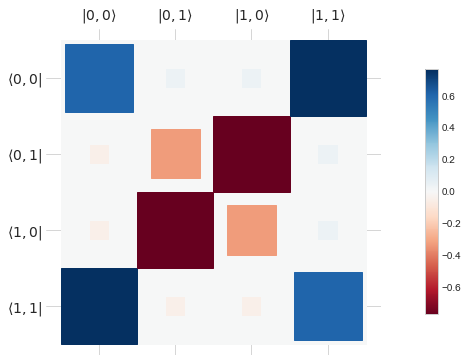

In [122]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [123]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [124]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([789.75374067+0.j, 556.96868729+0.j, 673.29548007+0.j,
       937.676596  +0.j, 435.41258631+0.j, 395.82353912+0.j,
       419.18694666+0.j, 452.63354314+0.j, 978.87088382+0.j,
       560.17413249+0.j, 242.34209716+0.j, 517.85472488+0.j,
       136.72789654+0.j, 515.55371161+0.j,  18.50448957+0.j,
       831.54123599+0.j, 376.12662475+0.j, 338.893785  +0.j,
       999.51140249+0.j, 487.11898296+0.j])

In [125]:
F(xi_opt, dt)

-3.092416218266722

In [126]:
max_iter

10

In [127]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [128]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.52072137+0.j         -0.07265601-0.00201343j -0.07265601+0.00201343j
   0.47927863+0.j        ]
 [ 0.07294427-0.00080992j  0.0321609 +0.00523571j  0.00923518+0.00458431j
  -0.07294427+0.00080992j]
 [ 0.07294427+0.00080992j  0.00923518-0.00458431j  0.0321609 -0.00523571j
  -0.07294427-0.00080992j]
 [ 0.47927863+0.j          0.07265601+0.00201343j  0.07265601-0.00201343j
   0.52072137+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119461390>)

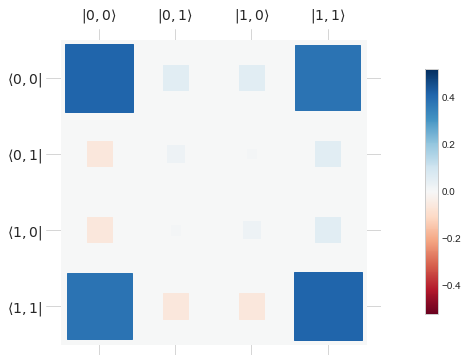

In [129]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [130]:
total_time = 4*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [131]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([921.5702214 +0.j, 756.62390835+0.j,  65.95312248+0.j,
       573.47364336+0.j, 106.91379795+0.j, 255.4183076 +0.j,
       703.75718151+0.j, 513.46546795+0.j, 854.34191328+0.j,
       432.34206428+0.j, 530.95697353+0.j, 212.40197576+0.j,
       781.41034017+0.j, 274.0190033 +0.j, 858.41249586+0.j,
       348.83942537+0.j, 254.12661776+0.j,  51.85833269+0.j,
         5.22903744+0.j, 629.88884338+0.j])

In [132]:
F(xi_opt, dt)

-3.023404166032716

In [133]:
max_iter

10

In [134]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [135]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.46134345+0.00000000e+00j -0.01188662+6.34450600e-05j
  -0.01188662-6.34450600e-05j  0.53865655+0.00000000e+00j]
 [ 0.01144117+2.61278484e-03j -0.03486451-2.32443413e-03j
  -0.04125944-5.13025647e-03j -0.01144117-2.61278484e-03j]
 [ 0.01144117-2.61278484e-03j -0.04125944+5.13025647e-03j
  -0.03486451+2.32443413e-03j -0.01144117+2.61278484e-03j]
 [ 0.53865655+0.00000000e+00j  0.01188662-6.34450600e-05j
   0.01188662+6.34450600e-05j  0.46134345+0.00000000e+00j]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a22ec5d68>)

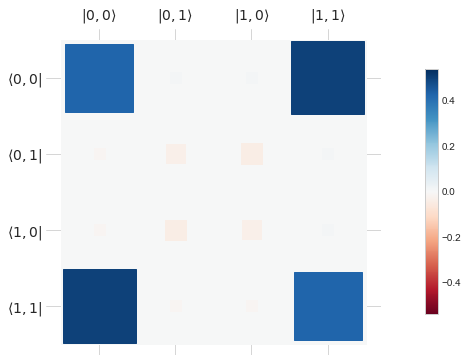

In [136]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [137]:
total_time = 5*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [138]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([130.8209312 +0.j, 884.89862915+0.j, 959.20321219+0.j,
       498.29494498+0.j, 355.84298734+0.j, 568.20249344+0.j,
       923.16070827+0.j, 844.81458222+0.j, 241.83831399+0.j,
       721.92677815+0.j, 499.08316577+0.j, 889.29270742+0.j,
       449.72399213+0.j, 435.78788133+0.j, 278.47756219+0.j,
       973.90977039+0.j, 367.88713662+0.j, 554.77033809+0.j,
       377.57633898+0.j, 541.75842192+0.j])

In [139]:
F(xi_opt, dt)

-3.007462360424914

In [140]:
max_iter

10

In [141]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [142]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.48694859+0.00000000e+00j  0.01722313-1.02067074e-04j
   0.01722313+1.02067074e-04j  0.51305141+0.00000000e+00j]
 [-0.01721472+4.00382681e-05j -0.01211542-2.90776019e-04j
  -0.01398246+1.94049302e-04j  0.01721472-4.00382681e-05j]
 [-0.01721472-4.00382681e-05j -0.01398246-1.94049302e-04j
  -0.01211542+2.90776019e-04j  0.01721472+4.00382681e-05j]
 [ 0.51305141+0.00000000e+00j -0.01722313+1.02067074e-04j
  -0.01722313-1.02067074e-04j  0.48694859+0.00000000e+00j]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23221f98>)

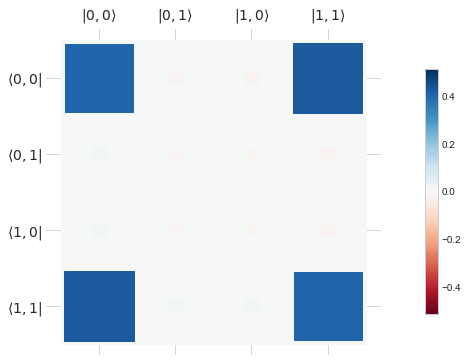

In [143]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [144]:
total_time = 10*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [145]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([223.7274885 +0.j, 639.62630204+0.j, 541.48785948+0.j,
       751.58436922+0.j, 764.8426518 +0.j, 296.00922486+0.j,
       126.15714927+0.j, 386.65578067+0.j, 373.67108782+0.j,
       551.03998792+0.j, 322.46822048+0.j, 896.89556233+0.j,
       743.82172746+0.j, 735.07660576+0.j, 339.24210679+0.j,
        86.60209728+0.j, 456.08411937+0.j, 310.91369033+0.j,
       512.73578685+0.j, 233.64748357+0.j])

In [146]:
F(xi_opt, dt)

-3.000013218736381

In [147]:
max_iter

10

In [148]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [149]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 4.99601314e-01+0.00000000e+00j -8.44451456e-04+8.78041811e-07j
  -8.44451456e-04-8.78041812e-07j  5.00398686e-01+0.00000000e+00j]
 [ 8.43925211e-04-1.97422006e-06j -3.96725596e-04+7.58652527e-06j
  -4.00247762e-04-3.24717202e-06j -8.43925211e-04+1.97422006e-06j]
 [ 8.43925211e-04+1.97422006e-06j -4.00247762e-04+3.24717202e-06j
  -3.96725596e-04-7.58652527e-06j -8.43925211e-04-1.97422006e-06j]
 [ 5.00398686e-01+0.00000000e+00j  8.44451456e-04-8.78041812e-07j
   8.44451456e-04+8.78041811e-07j  4.99601314e-01+0.00000000e+00j]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23283320>)

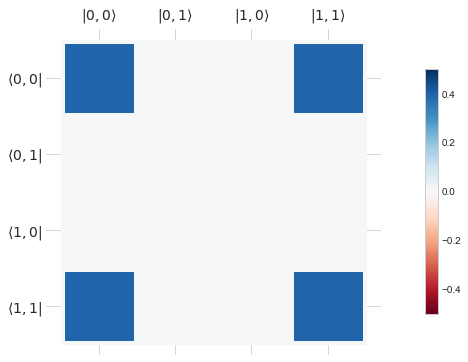

In [150]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [151]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 200
dt = total_time/time_steps

In [152]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([669.93282255+0.j, 855.41399193+0.j, 165.54949034+0.j,
       482.48858536+0.j, 342.62081729+0.j, 206.0307676 +0.j,
        77.38694075+0.j, 928.72262927+0.j, 998.41513427+0.j,
       246.8964603 +0.j, 738.44610915+0.j, 686.53431526+0.j,
       767.47644267+0.j, 416.29453042+0.j, 652.17942595+0.j,
       317.33050076+0.j, 659.06194186+0.j, 395.15892462+0.j,
       466.08489753+0.j, 951.99193941+0.j, 481.86586549+0.j,
       407.51861575+0.j, 579.64486577+0.j, 262.82841781+0.j,
       936.95958765+0.j, 515.61931657+0.j, 777.14590254+0.j,
       916.78003194+0.j, 336.84291003+0.j, 657.54373832+0.j,
       471.22309698+0.j, 565.44572085+0.j, 864.53446624+0.j,
       343.09491824+0.j, 798.31476124+0.j, 887.06739546+0.j,
       271.1093658 +0.j, 239.78865928+0.j, 761.52379115+0.j,
       641.9599327 +0.j, 328.99058299+0.j, 203.86798119+0.j,
       174.495657  +0.j, 380.26907774+0.j, 150.02915331+0.j,
       774.07224879+0.j, 664.37065901+0.j, 186.59876501+0.j,
       205.14649299+0.j,

In [153]:
F(xi_opt, dt)

-3.105557715080997

In [154]:
max_iter

10

In [155]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [156]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.45053501+0.j          0.05386567-0.00219087j  0.05386567+0.00219087j
   0.54946499+0.j        ]
 [-0.05576711-0.00175285j -0.04067547-0.00109118j -0.06444199+0.00917307j
   0.05576711+0.00175285j]
 [-0.05576711+0.00175285j -0.06444199-0.00917307j -0.04067547+0.00109118j
   0.05576711-0.00175285j]
 [ 0.54946499+0.j         -0.05386567+0.00219087j -0.05386567-0.00219087j
   0.45053501+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a232334a8>)

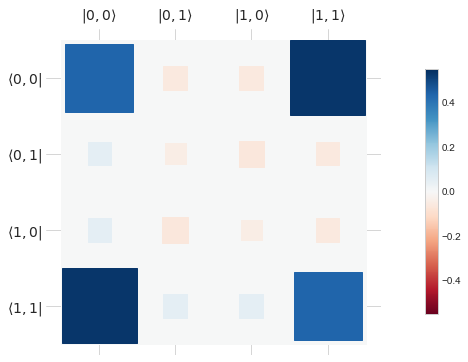

In [157]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [158]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 50
dt = total_time/time_steps

In [159]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([983.35006857+0.j, 854.18599804+0.j, 427.39158478+0.j,
       568.22      +0.j, 557.67520848+0.j, 215.20662373+0.j,
       531.89079128+0.j, 180.95001119+0.j, 985.00507013+0.j,
       285.75321228+0.j, 230.22505894+0.j, 392.17777385+0.j,
       911.97270469+0.j, 865.95937681+0.j, 719.17747998+0.j,
       614.34209737+0.j, 102.76796751+0.j, 122.0661469 +0.j,
       182.22958974+0.j, 641.75827772+0.j,  13.03504773+0.j,
       785.10642376+0.j, 268.16224425+0.j, 776.70699808+0.j,
       382.81870874+0.j, 269.94700403+0.j,  82.49822442+0.j,
       514.10921463+0.j, 917.88703593+0.j, 709.00061536+0.j,
       328.04657417+0.j, 510.19530155+0.j, 792.68882212+0.j,
       781.24520002+0.j, 636.8738876 +0.j, 884.35109957+0.j,
       125.25199229+0.j, 498.7457331 +0.j, 133.36702511+0.j,
       900.08614773+0.j, 225.70716339+0.j, 173.72539579+0.j,
       373.7743205 +0.j, 616.07328852+0.j, 173.27636418+0.j,
       915.84662279+0.j, 164.29794128+0.j, 802.09244618+0.j,
       185.7917225 +0.j,

In [160]:
F(xi_opt, dt)

-3.089390859721715

In [161]:
max_iter

10

In [162]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [163]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.43385111+0.j         -0.03689713-0.00166021j -0.03689713+0.00166021j
   0.56614889+0.j        ]
 [ 0.03697858-0.00070345j -0.05410633-0.00178289j -0.07692821+0.00852519j
  -0.03697858+0.00070345j]
 [ 0.03697858+0.00070345j -0.07692821-0.00852519j -0.05410633+0.00178289j
  -0.03697858-0.00070345j]
 [ 0.56614889+0.j          0.03689713+0.00166021j  0.03689713-0.00166021j
   0.43385111+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23289cf8>)

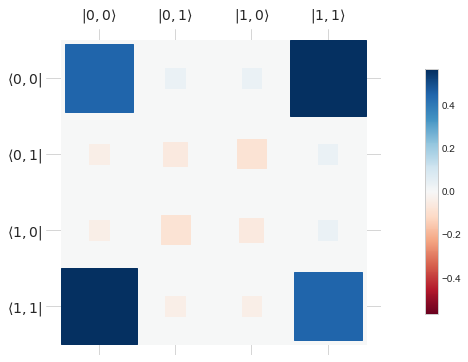

In [164]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [165]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 20#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [166]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([ 37.75150132+0.j, 207.82847072+0.j, 955.80557562+0.j,
       553.46393669+0.j, 180.58114193+0.j, 439.87340604+0.j,
       873.14596644+0.j, 376.56916437+0.j, 181.62899988+0.j,
       809.56553281+0.j,   8.81952599+0.j, 158.90623378+0.j,
       179.1560674 +0.j, 126.77723779+0.j, 735.44465353+0.j,
       986.33756807+0.j, 172.86957463+0.j, 487.83018464+0.j,
       564.83703258+0.j,  31.28685151+0.j])

In [167]:
F(xi_opt, dt)

-3.0924278039056157

In [168]:
max_iter

20

In [169]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [170]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.43438508+0.j          0.03592371-0.00581127j  0.03592371+0.00581127j
   0.56561492+0.j        ]
 [-0.03533659+0.00850701j -0.05528344-0.00690386j -0.07722724+0.00447405j
   0.03533659-0.00850701j]
 [-0.03533659-0.00850701j -0.07722724-0.00447405j -0.05528344+0.00690386j
   0.03533659+0.00850701j]
 [ 0.56561492+0.j         -0.03592371+0.00581127j -0.03592371-0.00581127j
   0.43438508+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a235c5b38>)

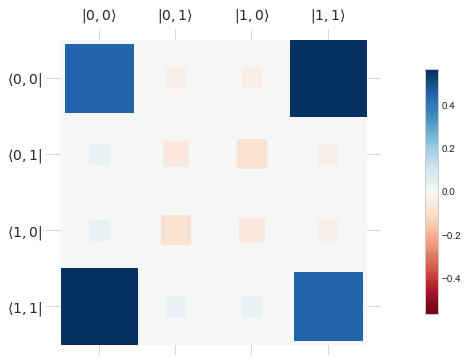

In [171]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [172]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 100#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [173]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([401.58366425+0.j, 743.60212539+0.j, 462.65261428+0.j,
       291.61275214+0.j, 997.20136871+0.j, 161.83255664+0.j,
       358.71205265+0.j, 397.6299681 +0.j, 115.56934024+0.j,
       265.02621297+0.j, 495.14132269+0.j, 681.28181627+0.j,
       379.03425381+0.j, 751.750218  +0.j, 868.3165758 +0.j,
       208.36118945+0.j, 571.48350418+0.j, 154.54000199+0.j,
       969.10320073+0.j, 104.39218721+0.j])

In [174]:
F(xi_opt, dt)

-3.092321460912429

In [175]:
max_iter

100

In [176]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [177]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.45849233+0.j          0.06352188-0.00055322j  0.06352188+0.00055322j
   0.54150767+0.j        ]
 [-0.06363213+0.00017884j -0.02989221-0.00176813j -0.05292961-0.0020041j
   0.06363213-0.00017884j]
 [-0.06363213-0.00017884j -0.05292961+0.0020041j  -0.02989221+0.00176813j
   0.06363213+0.00017884j]
 [ 0.54150767+0.j         -0.06352188+0.00055322j -0.06352188-0.00055322j
   0.45849233+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2387c080>)

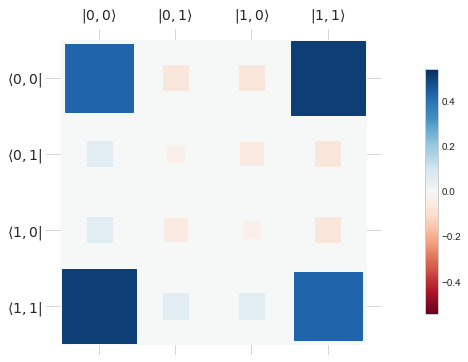

In [178]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [179]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 100#10**4#1000#100#50#20
time_steps = 200
dt = total_time/time_steps

In [180]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([3.19541626e+01+0.j, 1.79882345e+02+0.j, 5.18344505e+02+0.j,
       6.81949600e+02+0.j, 5.77987335e+02+0.j, 5.12877852e+02+0.j,
       7.83418724e+02+0.j, 9.63900338e+02+0.j, 3.51150366e+02+0.j,
       8.22079027e+02+0.j, 1.10161050e-01+0.j, 1.75657897e+02+0.j,
       1.63365268e+02+0.j, 9.71162009e+01+0.j, 6.21871551e+00+0.j,
       1.74438601e+01+0.j, 6.53094653e+02+0.j, 6.72290450e+02+0.j,
       5.44567526e+02+0.j, 8.17896893e+02+0.j, 9.97448926e+02+0.j,
       1.45873394e+00+0.j, 9.18461576e+02+0.j, 3.87575089e+02+0.j,
       6.30105653e+02+0.j, 8.30438981e+02+0.j, 4.94294323e+02+0.j,
       3.36328930e+02+0.j, 2.31625363e+02+0.j, 3.96915430e+02+0.j,
       2.49570092e+02+0.j, 1.73884194e+02+0.j, 9.49600192e+02+0.j,
       9.70697652e+02+0.j, 2.84651141e+02+0.j, 2.70328489e+01+0.j,
       6.98857845e+01+0.j, 5.93313689e+02+0.j, 2.44767186e+01+0.j,
       7.72234186e+02+0.j, 3.32272149e+01+0.j, 3.58435048e+02+0.j,
       6.15251995e+02+0.j, 3.90066512e+02+0.j, 4.33494394e+02+

In [181]:
F(xi_opt, dt)

-3.08713387614768

In [182]:
max_iter

100

In [183]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [184]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.55715523+0.j          0.04808016-0.00149918j  0.04808016+0.00149918j
   0.44284477+0.j        ]
 [-0.04537223-0.0055094j   0.06742228+0.02267533j  0.04672688-0.01129489j
   0.04537223+0.0055094j ]
 [-0.04537223+0.0055094j   0.04672688+0.01129489j  0.06742228-0.02267533j
   0.04537223-0.0055094j ]
 [ 0.44284477+0.j         -0.04808016+0.00149918j -0.04808016-0.00149918j
   0.55715523+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23861c18>)

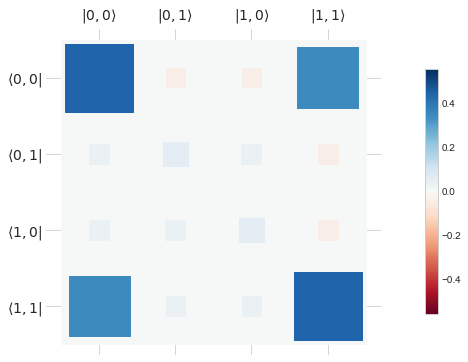

In [185]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [186]:
total_time = 3*pi/omega_1
epsilon = (0.1*2*pi)/(total_time)#10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [187]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([146.64691443+0.j, 749.78105269+0.j, 889.2844675 +0.j,
       558.74868247+0.j, 142.65208002+0.j, 783.26182885+0.j,
       255.59747005+0.j, 551.33485118+0.j, 220.74250203+0.j,
       885.37234198+0.j, 831.7905435 +0.j, 451.62602883+0.j,
       975.73768249+0.j, 723.78784668+0.j, 724.42037836+0.j,
       525.14088973+0.j, 196.835981  +0.j, 929.02565631+0.j,
       753.85742941+0.j, 608.14419261+0.j])

In [188]:
F(xi_opt, dt)

-3.092700262563744

In [189]:
max_iter

10

In [190]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [191]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.54690923+0.00000000e+00j -0.05967857+6.37856630e-05j
  -0.05967857-6.37856630e-05j  0.45309077+0.00000000e+00j]
 [ 0.05968888-2.27716642e-04j  0.0584485 -1.55517210e-04j
   0.03539348+1.93499291e-04j -0.05968888+2.27716642e-04j]
 [ 0.05968888+2.27716642e-04j  0.03539348-1.93499291e-04j
   0.0584485 +1.55517210e-04j -0.05968888-2.27716642e-04j]
 [ 0.45309077+0.00000000e+00j  0.05967857-6.37856630e-05j
   0.05967857+6.37856630e-05j  0.54690923+0.00000000e+00j]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a235ecf98>)

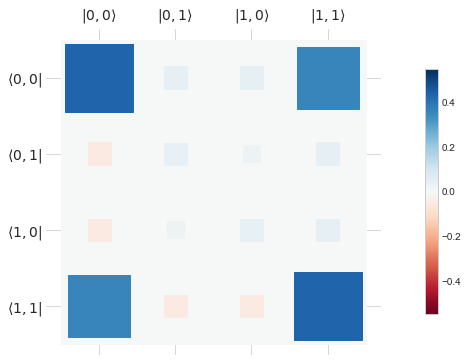

In [192]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [193]:
total_time = 3*pi/omega_1
epsilon = (0.1*2*pi)/(total_time)#10**(-6)
max_iter = 500#10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [194]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([272.1332443 +0.j,  62.49435768+0.j, 478.31559503+0.j,
       642.3570882 +0.j, 247.40237979+0.j, 858.88589277+0.j,
       699.57879076+0.j, 738.46010145+0.j, 458.97876102+0.j,
       690.72686689+0.j, 609.13766172+0.j, 913.046857  +0.j,
       842.45228207+0.j,  75.29612458+0.j, 518.10094757+0.j,
       609.6485885 +0.j, 380.96604687+0.j,  18.42243984+0.j,
       179.91927543+0.j, 531.91130855+0.j])

In [195]:
F(xi_opt, dt)

-3.0936564131157467

In [196]:
max_iter

500

In [197]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [198]:
myU = L_full_maker(xi_opt, dt)

In [199]:
myU/myU[0, 3]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.73806034+0.j         -0.00925049+0.00168568j -0.00925049-0.00168568j
   1.        +0.j        ]
 [ 0.00977569-0.00900906j -0.1113746 -0.00635185j -0.15145284-0.00637646j
  -0.00977569+0.00900906j]
 [ 0.00977569+0.00900906j -0.15145284+0.00637646j -0.1113746 +0.00635185j
  -0.00977569-0.00900906j]
 [ 1.        +0.j          0.00925049-0.00168568j  0.00925049+0.00168568j
   0.73806034+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23c55240>)

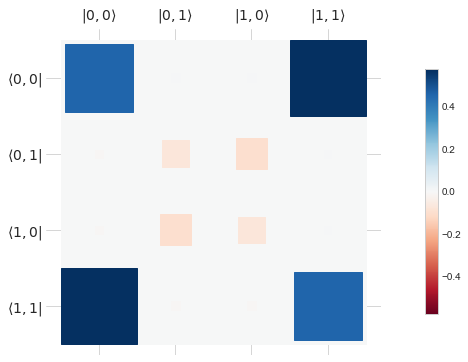

In [200]:
hinton(myU)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23e56b70>)

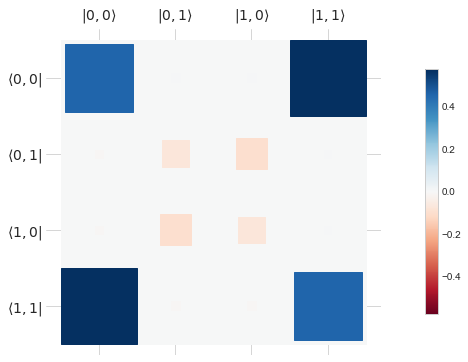

In [201]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [202]:
total_time = 3*pi/omega_1
epsilon = (0.1*2*pi)/(total_time)#10**(-6)
max_iter = 500#10#10**4#1000#100#50#20
time_steps = 500
dt = total_time/time_steps

In [203]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
#xi_opt

In [204]:
F(xi_opt, dt)

-3.0955282624024227

In [205]:
max_iter

500

In [206]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [207]:
myU = L_full_maker(xi_opt, dt)

In [208]:
myU/myU[0, 3]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.03075523+0.j         -0.15286451+0.00891654j -0.15286451-0.00891654j
   1.        +0.j        ]
 [ 0.15159851+0.00838859j  0.0359865 +0.00756527j -0.00967651-0.01738289j
  -0.15159851-0.00838859j]
 [ 0.15159851-0.00838859j -0.00967651+0.01738289j  0.0359865 -0.00756527j
  -0.15159851+0.00838859j]
 [ 1.        +0.j          0.15286451-0.00891654j  0.15286451+0.00891654j
   1.03075523+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23cf8588>)

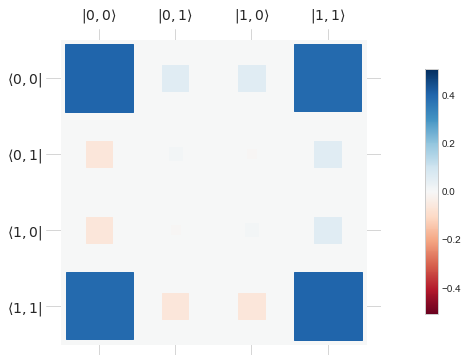

In [209]:
hinton(myU)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23f8e8d0>)

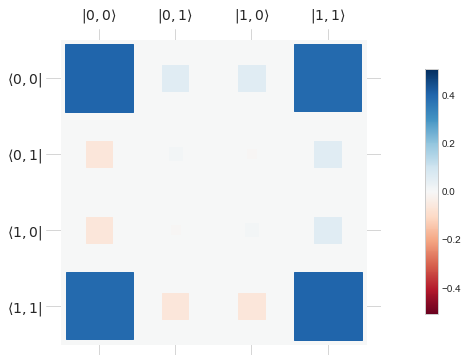

In [210]:
hinton(L_full_maker(xi_opt, dt))